In [ ]:
from google.colab import drive
# Mounts Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
##we upload tha datasets
df = pd.read_pickle("/content/drive/MyDrive/ProgettoDataMining/complete_df.pkl")

**CNN**

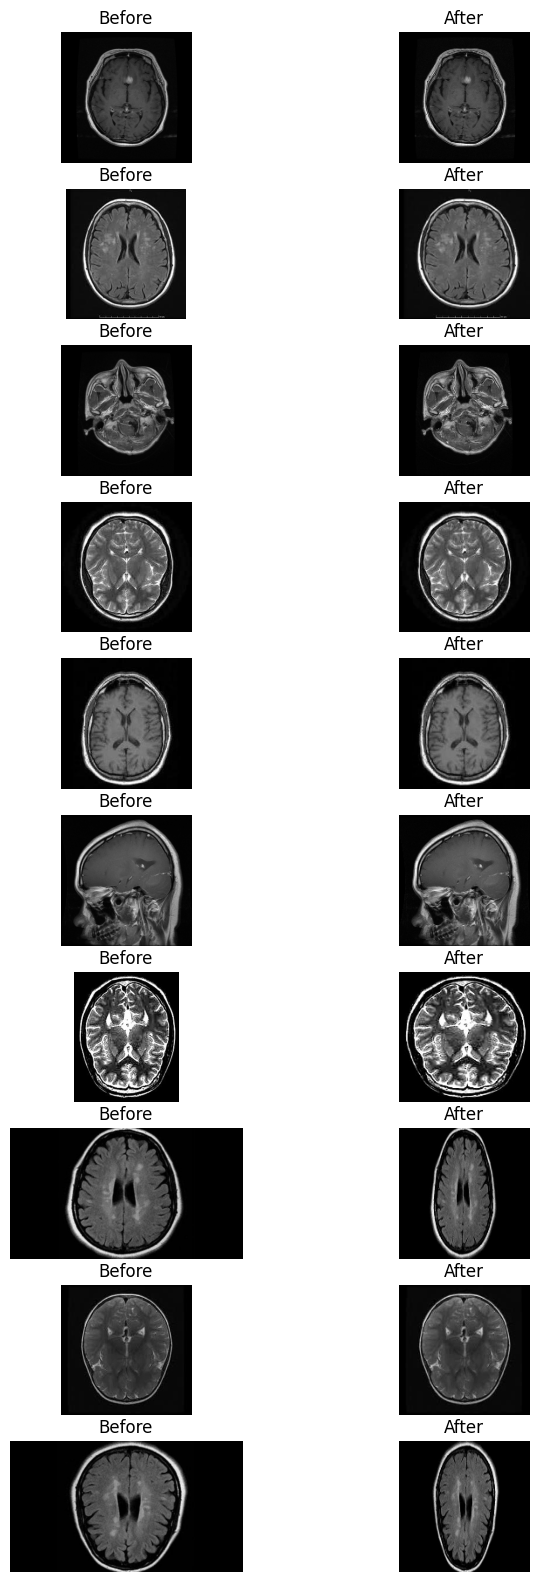

In [ ]:
import pandas as pd
import numpy as np
import cv2
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

class Resize:
    def __init__(self, df, size):
        self.dataframe = df
        self.size = size
        self.new_df = None

    def resize(self):
        self.new_df = self.dataframe.copy()
        for i in range(len(self.dataframe)):
            image = self.new_df.at[i, "Image"]
            new_image = cv2.resize(np.array(image, dtype=np.uint8), self.size)  # Convert to uint8
            self.new_df.at[i, "Image"] = new_image

    def show_resize(self, num_example, random_seed=50):
        if self.new_df is None:
            print("You have to apply the resize method before showing the resized images.")
        else:
            random.seed(random_seed)
            fig, axes = plt.subplots(num_example, 2, figsize=(8, 20))
            i = 0
            iterations = 0

            while i < num_example and iterations < 100:
                index = random.randint(0, len(self.dataframe) - 1)
                if pd.isna(self.new_df.at[index, "Image"]).all():
                    print("There is no image at index", index)
                    iterations += 1
                else:
                    image = np.array(self.dataframe.at[index, "Image"])
                    new_image = np.array(self.new_df.at[index, "Image"])

                    axes[i, 0].imshow(image, cmap="gray")
                    axes[i, 0].set_title("Before")
                    axes[i, 0].axis('off')

                    axes[i, 1].imshow(new_image, cmap="gray")
                    axes[i, 1].set_title("After")
                    axes[i, 1].axis('off')

                    i += 1
                    iterations += 1

            plt.show()

def create_matrix_of_columns_images(df, total=False, num_of_images=None, num_label=4):
    if total:
        dimension = len(df.at[0, "Image"].flatten())
        image_matrix = np.empty((dimension, len(df)))

        for i in range(len(df)):
            image = df.at[i, "Image"]
            image = image.flatten()
            image_matrix[:, i] = image
    else:
        num_row_df = num_of_images
        num = int(num_row_df / num_label)
        new = pd.DataFrame(columns=['Image', 'Label'])

        for label in df["Label"].unique():
            x = df.loc[df['Label'] == label]
            y = x.sample(n=num, random_state=1).reset_index(drop=True)
            new = pd.concat([new, y])

        new = new.sample(frac=1).reset_index(drop=True)

        print("Show balanced subselection", "\n", new["Label"].value_counts())

        dimension = len(new.at[0, "Image"].flatten())
        image_matrix = np.empty((dimension, len(new)))

        for i in range(len(new)):
            image = new.at[i, "Image"]
            image = image.flatten()
            image_matrix[:, i] = image

    image_matrix = image_matrix / 255.0

    return image_matrix

# Usage
size = (150, 150)
num_example = 10

resizer = Resize(df, size)
resizer.resize()
resizer.show_resize(num_example, 20)

# Convert images to numpy array and ensure they are in uint8 format
x_data = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in resizer.new_df["Image"].values])
x_data = x_data.reshape(-1, size[0], size[1], 3)  # Ensure 3 channels

# Prepare labels (assuming you have the labels in the 'Label' column and they are one-hot encoded)
y_data = pd.get_dummies(resizer.new_df["Label"]).values

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Clean up to save memory
resizer.dataframe = None
new_df = resizer.new_df
df = new_df

# Define the model
image_size = 150  # Resized image dimensions



In [ ]:
# Modify the model to accept single-channel (grayscale) input
net = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)  #
model = Model(inputs=net.input, outputs=model)

# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Define callbacks
logdir = "logs"  # Define your log directory
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1)
checkpoint = ModelCheckpoint(filepath='model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', restore_best_weights=True, verbose=1)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='min')

callbacks = [es, rl, tensorboard, checkpoint]

# Data augmentation
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
datagen.fit(x_train)

BATCH_SIZE = 64
EPOCHS = 50

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
# Save the final model
model.save('/content/drive/MyDrive/ProgettoDataMining/Res50')

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 83s 706ms/step - loss: 0.3883 - accuracy: 0.8485 - val_loss: 3.4167 - val_accuracy: 0.6024 - lr: 1.0000e-04
Epoch 2/50
58/58 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9356
Epoch 2: val_loss improved from 3.41667 to 2.09436, saving model to model-02-0.67-2.09.h5
58/58 [==============================] - 37s 625ms/step - loss: 0.1660 - accuracy: 0.9356 - val_loss: 2.0944 - val_accuracy: 0.6725 - lr: 1.0000e-04
Epoch 3/50
58/58 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9515
Epoch 3: val_loss improved from 2.09436 to 1.43404, saving model to model-03-0.76-1.43.h5
58/58 [==============================] - 37s 639ms/step - loss: 0.1221 - accuracy: 0.9515 - val_loss: 1.4340 - val_accuracy: 0.7558 - lr: 1.0000e-04
Epoch 4/50
58/58 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9589
Epoch 4: val_loss improved from 1.43404 to 1.36868, saving model to model-04-0.77-1.37.h5
5

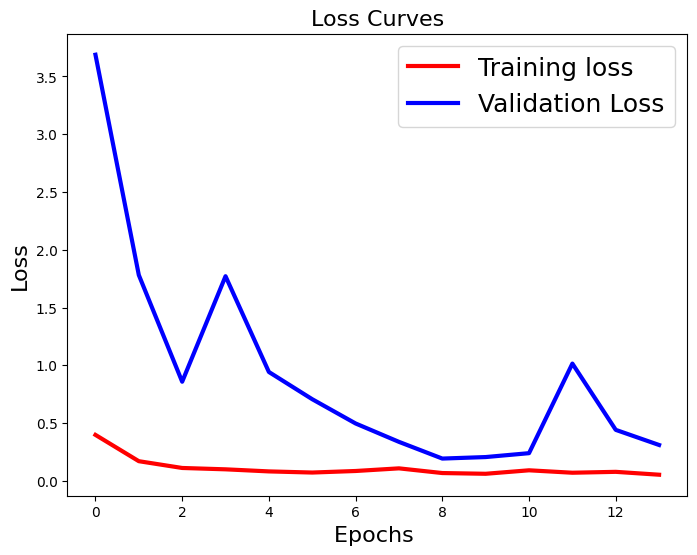

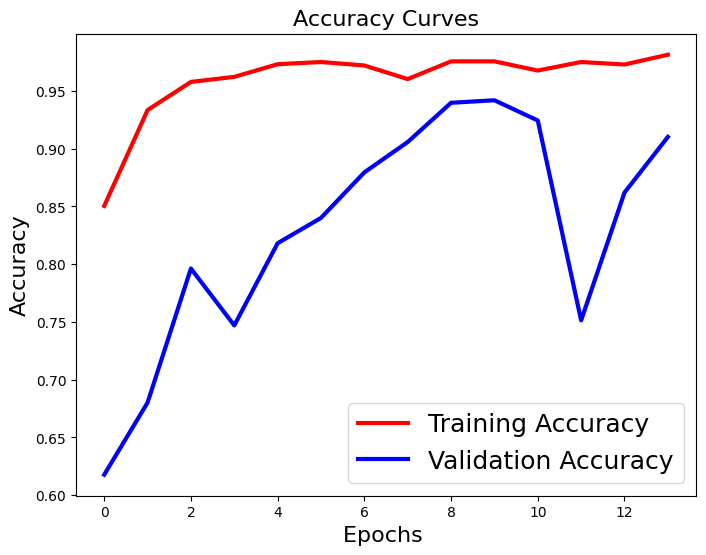

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

29/29 [==============================] - 2s 52ms/step
                 precision    recall  f1-score   support

         glioma       0.98      0.97      0.97       285
        notumor       0.96      0.94      0.95       191
pituitary tumor       0.91      0.94      0.92       155
     meningioma       0.99      1.00      0.99       282

       accuracy                           0.97       913
      macro avg       0.96      0.96      0.96       913
   weighted avg       0.97      0.97      0.97       913









<Figure size 2500x2500 with 0 Axes>

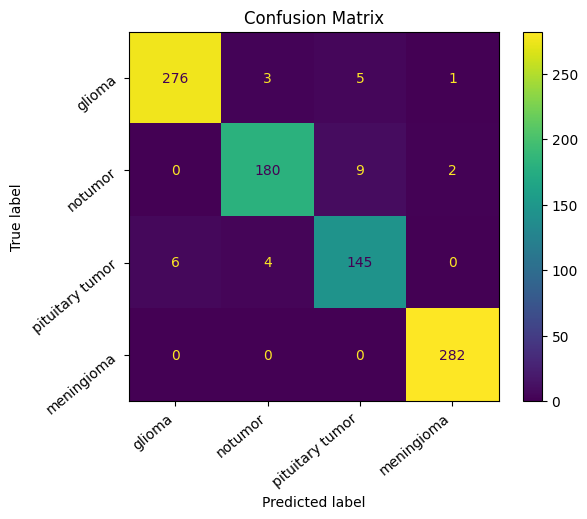

In [ ]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('/content/drive/MyDrive/ProgettoDataMining/Res50')
# Assuming 'Label' column contains the original labels
original_labels = resizer.new_df['Label'].unique()

# Define a function to evaluate the performance of a classification model using various metrics and visualizations.
def evaluate_metrics(y_pred, y_test, label_names):
    # Obtain and print unique labels from y_test and y_pred.
    labels = unique_labels(y_test, y_pred)
    # Generate and print a classification report showing precision, recall, F1-score, and support for each class.
    report = classification_report(y_test, y_pred, target_names=label_names)
    print(report)
    # Add spacing for clarity.
    print("\n" * 5)
    # Generate and display a confusion matrix.
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    plt.figure(figsize=(25, 25))
    cm_display.plot()
    plt.title('Confusion Matrix')
    plt.xticks(rotation=40, ha='right')
    plt.yticks(rotation=40, ha='right')
    plt.show()

# Predictions
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Map numeric classes to actual labels
y_pred_labels = [original_labels[i] for i in y_pred_classes]
y_val_labels = [original_labels[i] for i in y_val_classes]

# Evaluate the model
evaluate_metrics(y_pred_labels, y_val_labels, original_labels)
